# Trabajo práctico 1 - *Burnout en empleados corporativos*
*Pablo Brahim - Kevin Pennington*

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
%pip install imblearn
from imblearn.over_sampling import SMOTE

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 KB 11.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
df = pd.read_parquet("./dataset_burnout.parquet.gzip")

Queremos predecir el brunout de los empleados, usamos el burn_rate como proxy.<br>

Podemos plantear un problema de clasificacion binaria (por ejemplo si el burn rate es mayor que cierto umbral) <br>
Intentando predecir si un determinado empleado presenta o no *burnout* <br>

Otra opcion es intentar predecir el nivel de burnout, para esto seria necesario transformar el target<br>
en una variable categorica ordinal, con determinados niveles de *burnout* ya que, como vimos<br>
en el trabajo anterior esta variable es continua, con valores entre 0 y 1

Analizamos un poco la variable target para ver como discretizarla.<br>
Creamos cuatro categorias para el burnout: Bajo, Medio, Alto y Muy Alto<br>

<Axes: xlabel='burn_rate', ylabel='Count'>

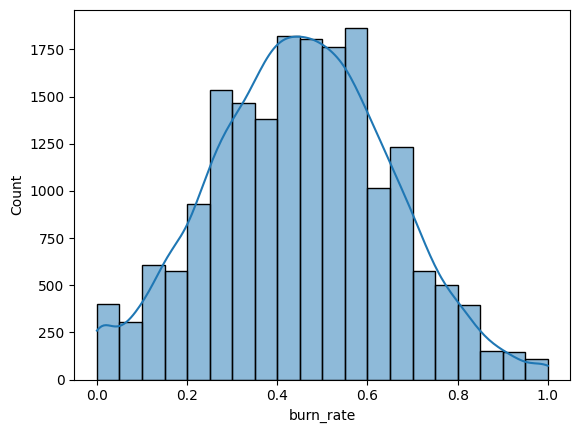

In [45]:
sns.histplot(data=df, x='burn_rate', bins=20, kde=True)

## Discretizacion target

In [46]:
""" helper function hecha en clase"""
def plot(new_var):
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    sns.histplot(data=df, x="burn_rate", hue=new_var, multiple="stack", bins=20, palette="Set2", ax=axes[0])
    axes[0].set_title(f"Histograma por categoría ({new_var})")
    axes[0].set_xlabel("burn_rate")
    axes[0].set_ylabel("Frecuencia")

    sns.scatterplot(data=df, x=df.index, y="burn_rate", hue=new_var, palette="Set2", ax=axes[1])
    axes[1].set_title('Discretización')
    axes[1].set_ylabel("Categoría")
    axes[1].set_xlabel("burn_rate" )

    sns.countplot(x=new_var, data=df, hue=new_var, palette="Set2", ax=axes[2])
    axes[2].set_xlabel("Categoría")
    axes[2].set_ylabel("Cantidad de empleados")
    axes[2].set_title("Distribución de empleados según burn rate")

    plt.tight_layout()
    plt.show()

### Intervalos igual longitud

En primer lugar probamos el caso mas sencillo que es dividir todo el rango de burn rate<br>
en intervalos de igual longitud<br>

In [145]:
df["equal_width"] = pd.cut(df["burn_rate"], bins=4, labels=["Bajo", "Medio", "Alto", "Muy Alto"])

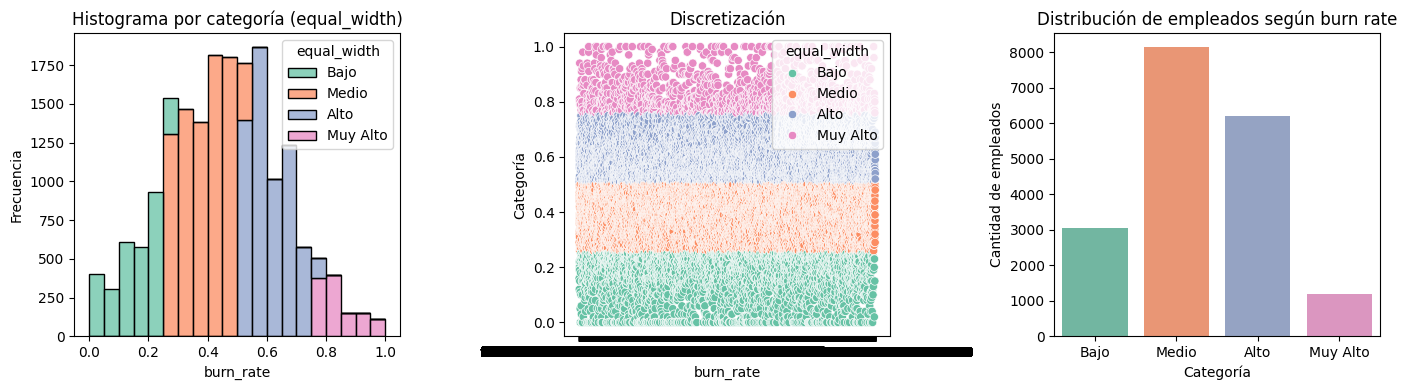

In [48]:
plot('equal_width')

Lo que tiene de positivo esta discretizacion es que la interpretacion de los rangos de burnout es clara<br>
el problema es que, naturalmente, los datos no se distribuyen uniformemente en esos intervalos.<br>
El desbalance de clases es muy alto; en particular, la forma de la cola de la distribucion hace <br>
que la clase "Muy Alto" tenga muy pocos valores comparativamente.

### Intervalos igual frecuencia

Se pueden separar en intervalos con la misma cantidad de cuentas para intentar remediar el desbalance de la discretizacion anterior<br>
La contra de esto es que los intervalos resultantes pueden no ser muy descriptivos<br>

In [146]:
df["equal_freq"], bins = pd.qcut(df["burn_rate"], q=4, labels=["Bajo", "Medio", "Alto", "Muy Alto"], retbins=True)

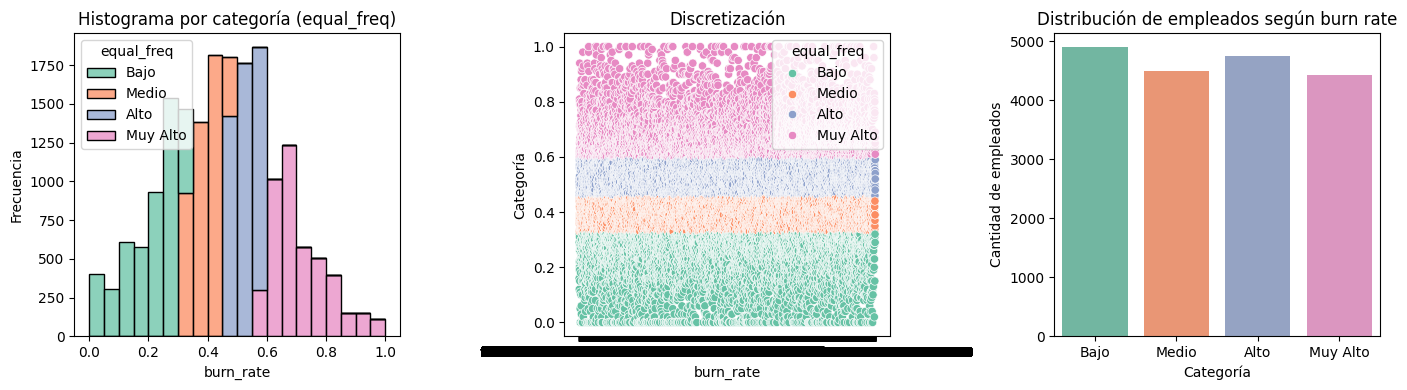

In [49]:
plot('equal_freq')

En efecto, el desbalance de clase mejora al punto de practicamente desaparecer. <br>
Pero los intervalos centrales son muy acotados y tienen muy poca dispersin<br>

### k-means cluster

Probamos con una clusterizacion por k-medias<br>

In [147]:
kbin_kmeans = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')
df["kbin_kmeans"] = kbin_kmeans.fit_transform(df[["burn_rate"]]).astype(int)

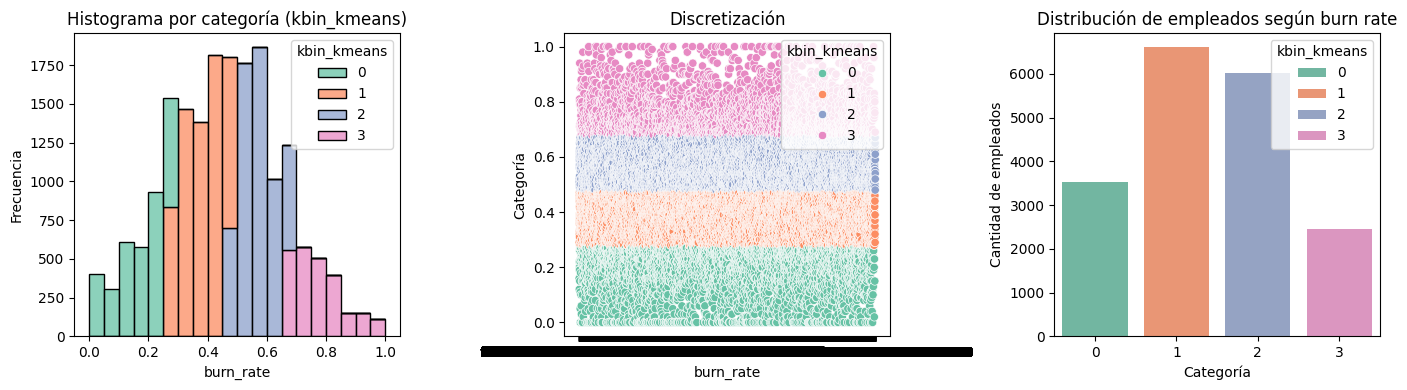

In [53]:
plot("kbin_kmeans")

En este caso, la discretizacion resultante parece un *punto medio* entre las dos anteriores.<br>
Existe desbalance (bastante marcado para la clase 3) pero no tanto como para los intervalos<br>
de igual longitud.
Los intervalos creados por esta clusterizacion estan un poco mejor distribuidos que los creados<br>
por los intervalos de mejor frecuencia.<br>

### Eleccion de discretizacion


In [75]:
print(f"desbalance de clases para intervalos de igual longitud: {df.equal_width.value_counts().iloc[0] / df.equal_width.value_counts().iloc[3]:.2f}")
print(f"desbalance de clases para intervalos de k-medias: {df.kbin_kmeans.value_counts().iloc[0] / df.kbin_kmeans.value_counts().iloc[3]:.2f}")

desbalance de clases para intervalos de igual longitud: 6.86
desbalance de clases para intervalos de k-medias: 2.71


Se puede ver que el desbalance de clases en el caso de k-medias es mucho mejor que para los intervalos de igual longitud<br>
Podemos cuantificar esto tambien mirando la entropia de shannon para las distintas variables<br>

In [99]:
def shannon_entropy(y):
    probs = y.value_counts(normalize=True)
    return -np.sum(probs * np.log2(probs))
print("Entropia de shannon")
print(f"intervalos de igual longitud:\t{shannon_entropy(df.equal_width):.2f}")
print(f"intervalos de igual frecuencia:\t{shannon_entropy(df.equal_freq):.2f}")
print(f"intervalos k medias:\t\t{shannon_entropy(df.kbin_kmeans):.2f}")

Entropia de shannon
intervalos de igual longitud:	1.73
intervalos de igual frecuencia:	2.00
intervalos k medias:		1.90


Creemos ademas que los rangos comprendidos por las distintas categorías para este caso son aceptables.<br>
Por este motivo, conservamos esta discretizacion para la variable target

In [106]:
df["burn_rate_disc"] = df.kbin_kmeans

In [148]:
df["burn_rate_disc"] = df.kbin_kmeans
df = df.drop(columns=["equal_width", "equal_freq", "kbin_kmeans"])
df.head(5)

,date_of_joining,gender,company_type,wfh_setup_available,designation,resource_allocation,mental_fatigue_score,burn_rate,work_hours_per_week,sleep_hours,work-life_balance_score,manager_support_score,deadline_pressure_score,team_size,recognition_frequency,day_of_joining,days_since_joined,burn_rate_disc
Employee ID,,,,,,,,,,,,,,,,,,
fffe32003000360033003200,2008-09-30,Female,Service,No,2,3.0,3.8,0.16,35,7.5,3,3,1,16,2,274,93,0
fffe3700360033003500,2008-11-30,Male,Service,Yes,1,2.0,5.0,0.36,41,7.1,5,3,3,10,5,335,32,1
fffe32003400380032003900,2008-11-03,Male,Service,Yes,1,1.0,2.6,0.20,43,6.7,3,3,1,13,2,308,59,0
fffe31003900340031003600,2008-07-24,Female,Service,No,3,7.0,6.9,0.52,51,5.2,1,3,4,18,0,206,161,2
fffe3300350037003500,2008-11-26,Male,Product,Yes,2,4.0,3.6,0.29,41,7.0,4,4,3,9,5,331,36,1


## Codificacion pre split

Hacemos una codificacion y tratamineto previo de las columnas del dataset.
Ya vimos en el trabajo anterior que las variables gender, company_type y wfh_setup_available toman<br>
dos valores posibles cada una. Por lo tanto, es directo mapearlos a 0,1 cada una.<br>
Ademas (tambien discutido en el TP 1) podemos dropear date_of_joining, ya que se crearon<br>
dos nuevos features que consideramos mas informativos que la fec

In [149]:
df["gender"] = df["gender"].map({"Male": 0, "Female": 1})
df["company_type"] = df["company_type"].map({"Service": 0, "Product": 1})
df["wfh_setup_available"] = df["wfh_setup_available"].map({"No": 0, "Yes": 1})
df = df.drop("date_of_joining", axis=1)

Ahora todas las variables son numéricas

In [150]:
df.head(5)

,gender,company_type,wfh_setup_available,designation,resource_allocation,mental_fatigue_score,burn_rate,work_hours_per_week,sleep_hours,work-life_balance_score,manager_support_score,deadline_pressure_score,team_size,recognition_frequency,day_of_joining,days_since_joined,burn_rate_disc
Employee ID,,,,,,,,,,,,,,,,,
fffe32003000360033003200,1,0,0,2,3.0,3.8,0.16,35,7.5,3,3,1,16,2,274,93,0
fffe3700360033003500,0,0,1,1,2.0,5.0,0.36,41,7.1,5,3,3,10,5,335,32,1
fffe32003400380032003900,0,0,1,1,1.0,2.6,0.20,43,6.7,3,3,1,13,2,308,59,0
fffe31003900340031003600,1,0,0,3,7.0,6.9,0.52,51,5.2,1,3,4,18,0,206,161,2
fffe3300350037003500,0,1,1,2,4.0,3.6,0.29,41,7.0,4,4,3,9,5,331,36,1


## Split train test / balance de clases

In [151]:
X = df.drop(columns=["burn_rate", "burn_rate_disc"], axis=1)
y = df.burn_rate_disc

En primer lugar hacemos el train test split para evitar data leakage. <br>
Como ademas el balance de clases lo hacemos para el train set<br>
usamos `stratify=y` en el split para granatizar cierta presencia de las clases<br>
con menor ocurrencia en el set de prueba.

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Tamaño train:", X_train.shape, "Test:", X_test.shape)

Tamaño train: (14872, 15) Test: (3718, 15)


<Axes: xlabel='burn_rate_disc', ylabel='count'>

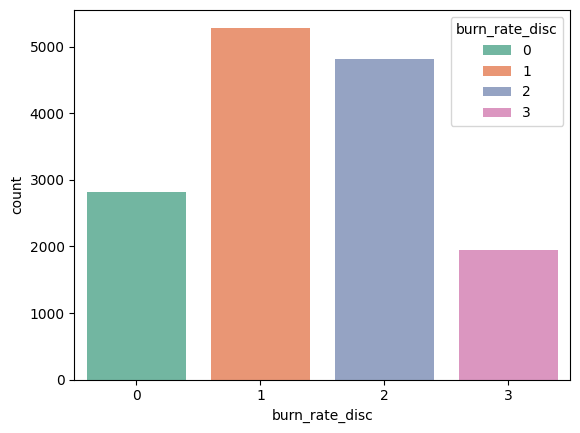

In [162]:
sns.countplot(x=y_train, hue=y_train, palette="Set2")

Para el set de entrenamiento, el dataset cuenta con menos de 2k muestras para<br>
la clase minoritaria. Descartamos por lo tanto hacer under sampling a las otras<br>
clases; ya queesto implicaría quedarse con cerca de 8k datos para entrenar<br>
contra los casi 15 con los que cuenta actualmente. 

In [155]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

<Axes: xlabel='burn_rate_disc', ylabel='count'>

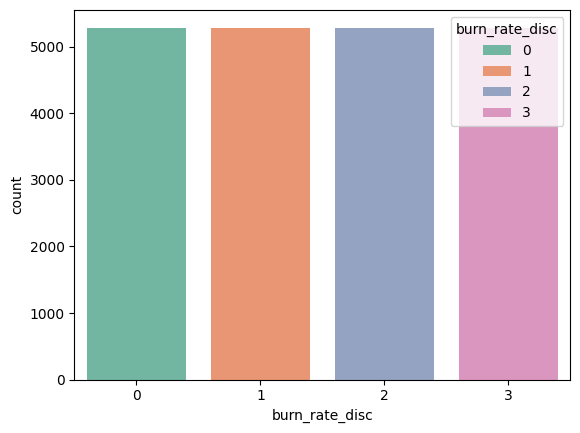

In [163]:
sns.countplot(x=y_train_sm, hue=y_train_sm, palette="Set2")

Por ahora podemos quedarnos con este set de entrenamiento. Hay que tener en cuenta <br>
sin embargo que este over sampling de las clases minoritarias podria provocar <br>
cierto overfitting al momento de entrenar el modelo. <br>
En este trabajo no llegamos a eso pero, si esto resulta en un problema <br> 
se podria buscar otra estrategia de balance, en primera instancia una <br>
estrategia mixta *downsampleando* un poco la clase mayoritaria, para que <br>
la síntesis de los datos minoritarios no sea tan grande.